# Imports and Other Initializations

So previously, we determined that the huggingface model was the best model among the three (VADER and RoBERTa). Therefore, this is the model we will use.

In [20]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
import zipfile
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

Let's use the IMDB Reviews dataset. (Link: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [2]:
# import torch

# # Check the number of available GPUs
# num_gpus = torch.cuda.device_count()

# # Print the number of CUDA cores per GPU
# for i in range(num_gpus):
#     print("GPU {} has {} CUDA cores.".format(i, torch.cuda.get_device_properties(i).multi_processor_count * 128))


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
os.chdir('datasets/')

if "IMDB Dataset.csv" not in os.listdir():
    IMDB_zip = zipfile.ZipFile("IMDB Movie Reviews.zip")
    IMDB_zip.extractall()
    IMDB_zip.close()

# Creating the DataFrame

In [5]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


We can see that the dataset only has 2 columns and 50,000 entries. Since we don't need to train the huggingface model, let's predict right away and compare the predictions to the true sentiments.

In [7]:
# Creating a column for the ID
df = df.reset_index().rename(columns={'index': 'ID'})

# Applying the Model to the Dataset

This can be done using Google Colab

In [8]:
# Preparing the model
# inference_model = pipeline("sentiment-analysis")

Using the huggingface model to make an inference on each entry of the IMDB Movie Review dataset

In [9]:
# model_predictions = {'predictions': [], 'ID': []}
# start = time.time()

# for ID in df['ID']:
#     try:
#         prediction = inference_model(df['review'][ID])
#         model_predictions['predictions'].append(prediction)
#         model_predictions['ID'].append(ID)
#     except RuntimeError:
#         print(f'Broke for ID {ID}')

# end = time.time()
# print(f'It took {np.round(end-start, 2)} to make an inference on the whole dataset')
# model_predictions

We can see that the model could not make an inference or having errors (RuntimeError to be specific) on numerous reviews (as shown in the ID number). We will need to clean the dataset to make a comparison between the predicted sentiment and the true ones.

# Preprocessing the Results

In [12]:
def encoded_values(series_arr, encoder):
    values = series_arr.to_numpy().reshape(-1,1)
    values = encoder.fit_transform(values)
    # If one-hot encoding was used
    try:
        values = values.toarray()
    except AttributeError:
        values = values
    return values
    
def get_accuracy(true_vals, predicted_vals):
    return np.round((predicted_vals/true_vals)*100, 2)

def get_rmse(true_vals, predicted_vals):
    return np.sqrt(mean_squared_error(true_vals, predicted_vals))

def make_inference(inference_model, df):
    model_predictions = {'review': [], 'prediction': [], 'score':[]}
    for ID in df['ID']:
        try:
            prediction = inference_model(df['review'][ID])
            model_predictions['review'].append(df['review'][ID])
            model_predictions['prediction'].append(prediction[0]['label'])
            model_predictions['score'].append(prediction[0]['score'])
        except RuntimeError:
            print(f'Unable to infer ID {ID}')
    df2 = pd.DataFrame(model_predictions)
    df2.to_csv('model_predictions.csv', index=False)        
    return df2

In [14]:
# Load the csv
if os.path.exists("model_predictions.csv"):
    df2 = pd.read_csv("model_predictions.csv")    
else:
    import joblib
    VERSION = '0.1.0'
    inference_model = joblib.load(f"sentiment_analysis_model-{VERSION}.pkl")
    df2 = make_inference(inference_model, df)

# To remove the broken IDs from the original dataframe
mask = df['review'].isin(df2['review'])
df_filtered = df[mask]
df_filtered

# merging the two dataframes
final_df = df2.merge(df_filtered, how='right')

In [15]:
correct_predictions = 0
total = len(final_df['sentiment'])

for index, row in final_df.iterrows():
    prediction = row['prediction'].lower()
    if prediction == row['sentiment']:
        correct_predictions += 1

In [16]:
ordinal_true_vals = encoded_values(final_df['sentiment'], OrdinalEncoder())
ordinal_pred_vals = encoded_values(final_df['prediction'], OrdinalEncoder())

one_hot_true_vals = encoded_values(final_df['sentiment'], OneHotEncoder())
one_hot_pred_vals = encoded_values(final_df['prediction'], OneHotEncoder())

# Performance of the Inference Model

## Accuracy, MSE, and RMSE

In [17]:
print(f'Accuracy: {get_accuracy(total, correct_predictions)}%')
print(f'Mean Squared Error: {np.round(mean_squared_error(ordinal_true_vals, ordinal_pred_vals)*100,2)} (Ordinal)\t{np.round(mean_squared_error(one_hot_true_vals, one_hot_pred_vals)*100,2)} (OneHot)')
print(f'RMSE: {np.round(get_rmse(ordinal_true_vals, ordinal_pred_vals)*100,2)} (Ordinal)\t{np.round(get_rmse(one_hot_true_vals, one_hot_pred_vals)*100,2)} (OneHot)')

Accuracy: 90.05%
Mean Squared Error: 9.95 (Ordinal)	9.95 (OneHot)
RMSE: 31.55 (Ordinal)	31.55 (OneHot)


## Precision, Recall, and F1-Score

In [18]:
print('ORDINAL ENCODED')
print('Precision: ', np.round(precision_score(ordinal_true_vals, ordinal_pred_vals)*100,2))
print('Recall: ', np.round(recall_score(ordinal_true_vals, ordinal_pred_vals)*100,2))
print('F1 Score: ', np.round(f1_score(ordinal_true_vals, ordinal_pred_vals)*100,2))

print('\nONE HOT ENCODED')
print('Precision: ', np.round(precision_score(one_hot_true_vals.argmax(axis=1), one_hot_pred_vals.argmax(axis=1), average='macro')*100, 2))
print('Recall: ', np.round(recall_score(one_hot_true_vals.argmax(axis=1), one_hot_pred_vals.argmax(axis=1), average='macro')*100, 2))
print('F1-Score: ', np.round(f1_score(one_hot_true_vals.argmax(axis=1), one_hot_pred_vals.argmax(axis=1), average='macro')*100, 2))

ORDINAL ENCODED
Precision:  91.25
Recall:  88.33
F1 Score:  89.77

ONE HOT ENCODED
Precision:  90.1
Recall:  90.03
F1-Score:  90.04


The mean squared error and RMSE using both encoders were similar; however, there was a slight deviation in terms of precision, recall, and F1-score.

## Confusion Matrix

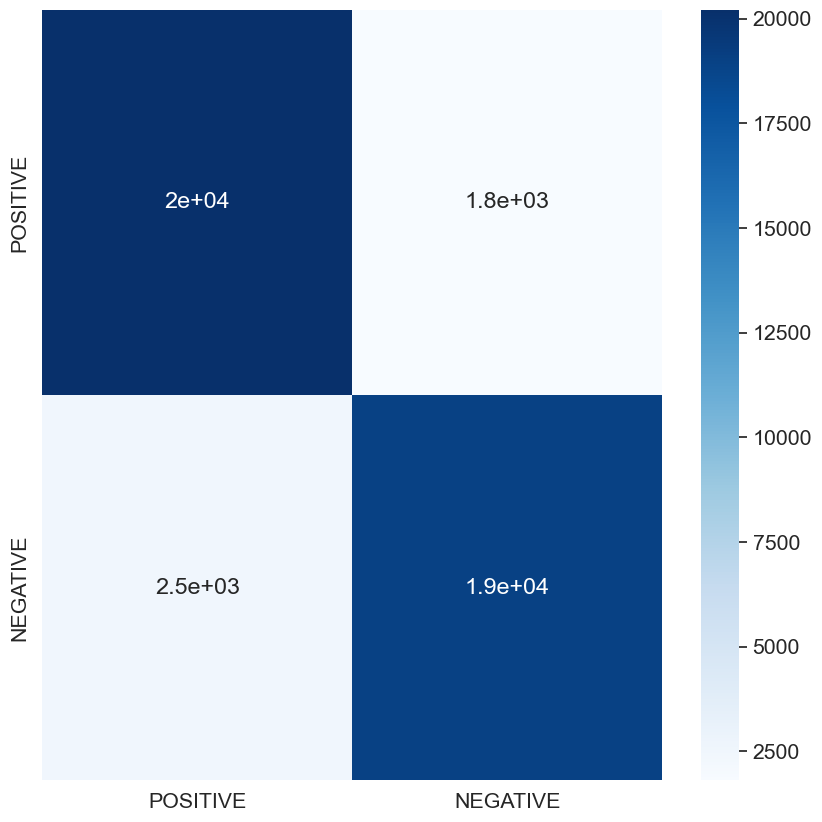

In [23]:
conf_mx = confusion_matrix(one_hot_true_vals.argmax(axis=1), one_hot_pred_vals.argmax(axis=1))
labels = ['POSITIVE', 'NEGATIVE']
plt.figure(figsize=(10,10))
sns.set(font_scale=1.4)
sns.heatmap(conf_mx, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.show()

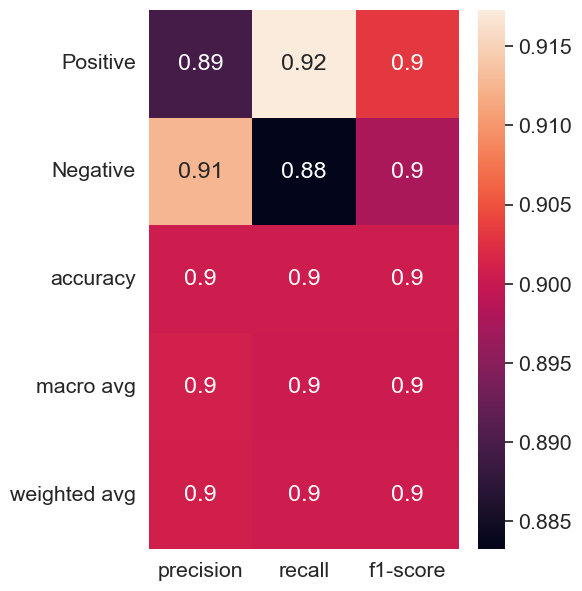

In [25]:
cr = classification_report(one_hot_true_vals.argmax(axis=1), one_hot_pred_vals.argmax(axis=1), target_names=['Positive', 'Negative'], output_dict=True)
plt.figure(figsize=(5,7))
sns.heatmap(pd.DataFrame(cr).iloc[:-1,:].T, annot=True)
plt.show()

# Conclusion

Using the Huggingface Model with the IMDB Reviews dataset resulted in a good prediction performance. The scores in precision, recall, and F1-Score were around 90% indicating a good model for deployment. This can be used to future review entries and check with minimal supervision to validate the model's result.